## Lorenz System and Chaos

The Lorenz system of coupled, ordinary, first-order differential equations have chaotic solutions for certain parameter values $σ$, $ρ$ and $β$ and initial conditions, $u(0)$, $v(0)$ and $w(0)$. The Lorenz equations (published in 1963 by Edward N. Lorenz a meteorologist and mathematician) are derived to model some of the unpredictable behavior of weather. 

$$
 \begin{gather}
    \begin{aligned}
        \frac{du}{dt} = σ(v-u) \\
        \frac{dv}{dt} = ρu−v−uw \\
        \frac{dv}{dt} = uv−βw
    \end{aligned}
\end{gather}
$$


In [1]:
import numpy as np
import scipy as sp
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# https://scipython.com/blog/the-lorenz-attractor/
def create_lorenz_attractor_dataset(tmax, dt):

    # Dynamics of The Model
    def lorenz(t, X, sigma, beta, rho):
        """The Lorenz equations."""
        u, v, w = X
        up = -sigma*(u - v)
        vp = rho*u - v - u*w
        wp = -beta*w + u*v
        return up, vp, wp

    # Lorenz paramters and initial conditions.
    sigma, beta, rho = 10, 8./3, 28
    u0, v0, w0 = 1, 1, 1

    # Integrate the Lorenz equations.
    soln = solve_ivp(lorenz, (0, tmax), (u0, v0, w0), args=(sigma, beta, rho), dense_output=True)

    # Interpolate solution onto the time grid, t.
    t = np.linspace(0, tmax, dt)
    Z = soln.sol(t)

    return t, Z

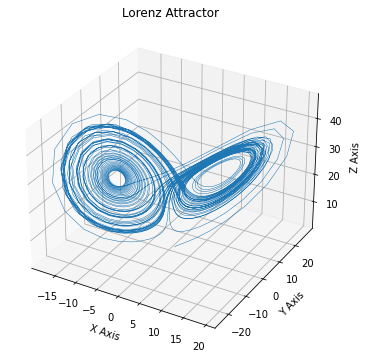

In [2]:
def show_lorenz_attractor(Z):
    ax = plt.figure(figsize=(12,6)).add_subplot(projection='3d')
    ax.plot(Z[0], Z[1], Z[2], lw=0.5)
    ax.set_xlabel("X Axis")
    ax.set_ylabel("Y Axis")
    ax.set_zlabel("Z Axis")
    ax.set_title("Lorenz Attractor")
    plt.show()

tmax = 60
dt = 2000

# Create Chaos dataset
t, Z = create_lorenz_attractor_dataset(tmax, dt)
show_lorenz_attractor(Z)

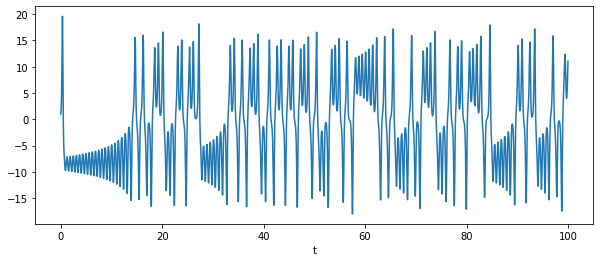

In [3]:
def show_lorenz_attractor_X(dt, X):
    fig = plt.figure(figsize=(10,4))
    ax = fig.add_subplot(111)
    ax.plot(dt, X, linestyle='solid')
    ax.set_xlabel("t")
    plt.show()
    
tmax = 100
dt = 10000

t, Z = create_lorenz_attractor_dataset(tmax, dt)
show_lorenz_attractor_X(t, Z[0])

## Forecasting Chaotic Time-Series via Recurrent Neural Networks (RNNs)

In [4]:
import random
import torch
from torch import nn

class RNNLayer(nn.Module):
    """RNN Layer

    Parameters:
        input_size: Number of input neurons
        hidden_size: Number of hidden neurons
        dt: discretization time step in ms. 
            If None, dt equals time constant tau

    Inputs:
        input: tensor of shape (seq_len, batch, input_size)
        hidden: tensor of shape (batch, hidden_size), initial hidden activity
            if None, hidden is initialized through self.init_hidden()
        
    Outputs:
        output: tensor of shape (seq_len, batch, hidden_size)
        hidden: tensor of shape (batch, hidden_size), final hidden activity
    """

    def __init__(self, input_size, hidden_size, dt=None, **kwargs):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.input2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)

    def init_hidden(self, input_shape):
        batch_size = input_shape[1]
        return torch.zeros(batch_size, self.hidden_size)

    def recurrence(self, input, hidden):
        """Run network for one time step.
        
        Inputs:
            input: tensor of shape (batch, input_size)
            hidden: tensor of shape (batch, hidden_size)
        
        Outputs:
            h_new: tensor of shape (batch, hidden_size),
                network activity at the next time step
        """
        h_new = torch.tanh(self.input2h(input) + self.h2h(hidden))
        return h_new

    def forward(self, input, hidden=None):
        """Propogate input through the network."""
        
        # If hidden activity is not provided, initialize it
        if hidden is None:
            hidden = self.init_hidden(input.shape).to(input.device)

        output = []
        # Loop through time
        for i in range(input.size(0)):
            hidden = self.recurrence(input[i], hidden)
            output.append(hidden)
        # Stack together output from all time steps
        output = torch.stack(output, dim=0)  # (seq_len, batch, hidden_size)
        return output, hidden

class RNNNet(nn.Module):
    """Recurrent network model.

    Parameters:
        input_size: int, input size
        hidden_size: int, hidden size
        output_size: int, output size
    
    Inputs:
        x: tensor of shape (Seq Len, Batch, Input size)

    Outputs:
        out: tensor of shape (Seq Len, Batch, Output size)
        rnn_output: tensor of shape (Seq Len, Batch, Hidden size)
    """
    def __init__(self, input_size, hidden_size, output_size, **kwargs):
        super().__init__()

        self.rnn = RNNLayer(input_size, hidden_size, **kwargs)
        self.do = nn.Dropout(p=0.2)
        self.fc = nn.Linear(hidden_size, output_size)

        # Default mode is teacher forcing
        self.teacher_forcing_ratio = 0.0

    def forward(self, x, hidden=None):
        use_teacher_forcing = True if random.random() > self.teacher_forcing_ratio else False
        if use_teacher_forcing:
            rnn_output, _ = self.rnn(x)
            if enable_do:
                rnn_output = self.do(rnn_output)
            out = self.fc(rnn_output)
            return out, rnn_output
        else:
            # If hidden activity is not provided, initialize it
            if hidden is None:
                hidden = self.rnn.init_hidden(input.shape).to(input.device)

            rnn_output = []
            x_t = input[0]
            # Loop through time
            for i in range(input.size(0)):
                hidden = self.rnn.recurrence(x_t, hidden)
                rnn_output.append(hidden)
                if enable_do:
                    hidden = self.do(hidden)
                x_t = self.fc(hidden)
            # Stack together output from all time steps
            output = torch.stack(rnn_output, dim=0)  # (seq_len, batch, hidden_size)
            if enable_do:
                rnn_output = self.do(rnn_output)
            out = self.fc(output)
            return out, rnn_output


## Define the Dataset

In [5]:
def normalize(data, train_set=None):
    """
    Scale data to range (0,1) accodring to minimum and maximum of data
    """
    if train_set==None:
        train_set = data
    return (data-train_set.min(axis=0))/(train_set.max(axis=0)-train_set.min(axis=0))

In [6]:
from sklearn.preprocessing import MinMaxScaler

# Discard % of Data
split_ratio = 0.5
split_index = int(split_ratio * len(t))
t = t[split_index:]
X = Z[0][split_index:]

# Normalize the Data
X = normalize(X)

# The input to the RNN is a time-delay-embedded matrix of X(t) with embedding dimension q (also known as lookback; Kim et al., 1999).
q = 10
X_train = np.expand_dims(X, axis=1)
X_train_step = np.zeros((q, len(t)-q, 1))
for s in range(len(X)-q):
    for step in range(q-1, -1, -1):
        X_train_step[step, s, :] = X_train[s+q-step-1, :]
Y_train = X[q:]

# X has the form nsteps x samples x input_dim
# Y has the form samples x input_dim
X_train_step = torch.from_numpy(X_train_step).type(torch.float)
X_train_step_ss = torch.clone(X_train_step)
Y_train = torch.from_numpy(Y_train).type(torch.float)

## Train the Recurrent Neural Network (RNN) via Teacher-forcing

Teacher forcing is a technique that is frequently used in dynamical supervised learning tasks where the model (student) receives the ground truth output $d(t)$ (teacher) in the subsequent computation of the behaviour of the network. In our context, this framework allows us to design tasks that we understand perfectly, and since the teacher and student are both neural networks with the same activation function, we also know that the student is, in principle, capable of imitating the teacher flawlessly.

In [7]:
# Set flags
enable_do = False
sgd = False
adam = True

In [8]:
# Init RNN model
hidden_dim = 200
net = RNNNet(1, hidden_dim, 1)

if sgd:
    optimizer = torch.optim.SGD(net.parameters(), lr=1e-3)
if adam:
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

loss_func = nn.MSELoss()

# Number of iterations treated as burn-in
burn_in_period = 100

for epoch in range(2000):
    # Reset State and Burn-in
    net(X_train_step[:,0:burn_in_period,:])

    optimizer.zero_grad()
    input = X_train_step[:,burn_in_period:,:]
    pred, _ = net(input)

    loss = loss_func(pred[q-1,:,0], Y_train[burn_in_period:])
    loss.backward()
    optimizer.step()

    if epoch%20==0:
        print(epoch, loss.data.item())

0 0.4477478265762329
20 0.040519531816244125
40 0.023824743926525116
60 0.021495241671800613
80 0.01731685921549797
100 0.014720884151756763
120 0.011575279757380486
140 0.009014011360704899
160 0.006725245621055365
180 0.012798148207366467
200 0.00493167107924819
220 0.003867423627525568
240 0.0029837090987712145
260 0.0031586959958076477
280 0.002425077836960554
300 0.0024298003409057856
320 0.0023778146132826805
340 0.001783678773790598
360 0.0014912676997482777
380 0.0015336094656959176
400 0.001252134912647307
420 0.00126145058311522
440 0.001118166372179985
460 0.0013425593497231603
480 0.0011861880775541067
500 0.001407277537509799
520 0.0010688069742172956
540 0.0008660116582177579
560 0.0008722302154637873
580 0.001221108715981245
600 0.0008265707874670625
620 0.0010041318600997329
640 0.0008929340401664376
660 0.0007294435054063797
680 0.0010502766817808151
700 0.0007173084886744618
720 0.000809871475212276
740 0.0014661652967333794
760 0.0007451458368450403
780 0.00068742880

In [9]:
def plot_time_series(true, pred, label):
    fig = plt.figure(figsize=(10,4))
    ax = fig.add_subplot(111)
    ax.plot(true, label="True")
    ax.plot(pred, label="Pred")
    ax.set_xlabel("t")
    ax.legend(loc=1)
    ax.set_title(label)
    plt.show()

## Generate the Recurrent Neural Network (RNN) Predictions at Training Points

0.00046521256


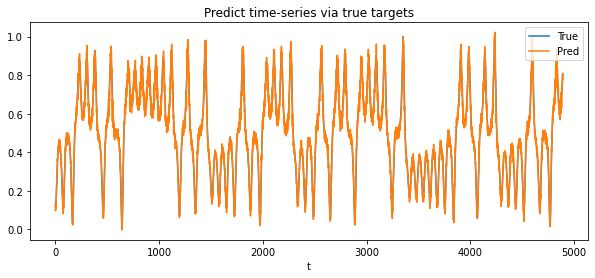

In [10]:
# Reset & Burn-in
net(X_train_step[:,0:burn_in_period,:])

# Predict time-series via true targets
pred, _ = net(X_train_step[:,burn_in_period:,:])

# Compute loss
error = loss_func(pred[-1,:,:].view(-1), Y_train[burn_in_period:]).detach().numpy()
print(error)

# Plot predictions
plot_time_series(X[burn_in_period+q:], pred[-1,:,:].view(-1).detach().numpy(), "Predict time-series via true targets")

## Forecasting the time-series with a seed input

0.16960923


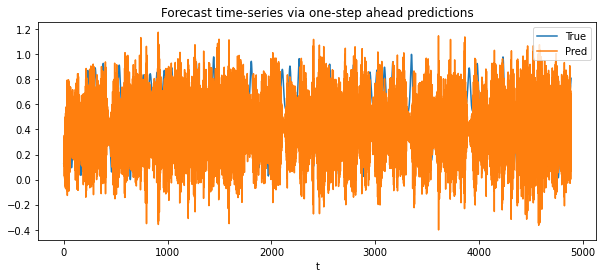

In [11]:
def one_step_ahead(net, data, n_predictions):
    """
    Generally, time series forecasting describes predicting the observation at the next time step. This is called a one-step forecast.
    The recursive strategy involves using a one-step model multiple times where the prediction for the prior time step is used as an input for making a prediction on the following time step.
    """
    pred = []
    for _ in range(n_predictions):
        y_t, _ = net.forward(data)
        data[0:q-1,:,:] = data[1:q,:,:].clone()
        data[q-1,:,:] = y_t[q-1,:,:]
        pred.append(data.detach().numpy()[-1,0,0])
    return pred

# Reset State & Burn-in
net(X_train_step[:,0:burn_in_period,:])

# Forecast time-series via one-step ahead predictions
data = X_train_step[0:q,0+burn_in_period:1+burn_in_period,:]
one_step = one_step_ahead(net, data, X_train_step[:,burn_in_period:,:].shape[1])
one_step = np.asarray(one_step)

# Compute loss
error = loss_func(torch.from_numpy(one_step), Y_train[burn_in_period:]).detach().numpy()
print(error)

# Plot predictions
plot_time_series(X[burn_in_period+q:], one_step, "Forecast time-series via one-step ahead predictions")

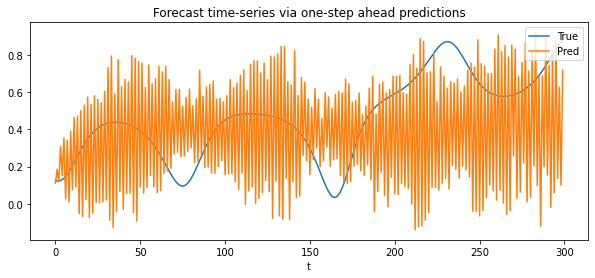

In [20]:
# Plot predictions
len = 300
plot_time_series(X[burn_in_period+q:burn_in_period+q+len], one_step[0:len], "Forecast time-series via one-step ahead predictions")

## Comparison target time-series FT and hidden activity FT

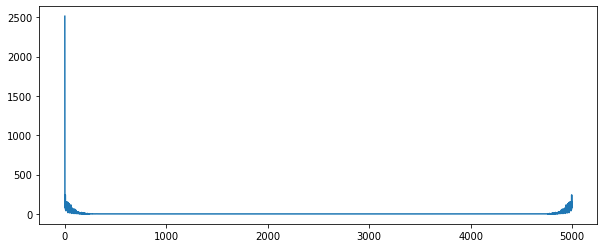

In [13]:
# FFT of target time-series
sp = np.fft.fft(X)

fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
ax.plot(abs(sp))
plt.show()

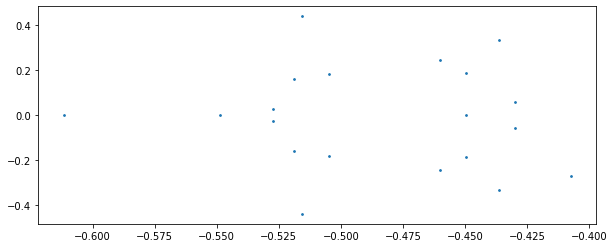

In [23]:
def extract_eigen_values(M):
    eW = np.linalg.eigvals(M)
    idx = eW.argsort()
    rea = [n.real for n in eW[idx]]
    imag = [n.imag for n in eW[idx]]
    return rea, imag

realW_bptt, imagW_bptt = extract_eigen_values(net.rnn.h2h.weight.detach().numpy())

top_eW = 20
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
ax.scatter(realW_bptt[0:top_eW], imagW_bptt[0:top_eW], s=3)
plt.show()

# Supplementary Material

## Train the Recurrent Neural Network (RNN) via Scheduled-Sampling

During inference, the model totally depends on itself where we provide both the inputs from previous output. If the model outputs a bad output at a certain step, it in turn affects the whole sequence ahead. This problem is known as *Exposure Bias Problem*.

[Scheduled Sampling](#ref1) is a method proposed to mitigate the bias where in the model randomly chooses from where to sample during Training. That is whether to provide the ground truth as an input to next time step or to provide the output produced in the previous time step as both the inputs as it is supposed to be in the inference time.

In [15]:
enable_ss = False

In [16]:
if enable_ss:
    # Init RNN model
    hidden_dim = 200
    net_ss = RNNNet(1, hidden_dim, 1)

    optimizer = torch.optim.Adam(net_ss.parameters(), lr=1e-3)
    loss_func = nn.MSELoss()

    # Number of iterations treated as burn-in
    burn_in_period = 100

    for epoch in range(2000):
        # Reset State and Burn-in
        net_ss(X_train_step_ss[:,0:burn_in_period,:])

        # net_ss.teacher_forcing_ratio = 0.5
        # Gradient descent after each epoch
        optimizer.zero_grad()
        input = X_train_step_ss[:,burn_in_period:,:]
        pred, _ = net_ss(input)

        loss = loss_func(pred[q-1,:,0], Y_train[burn_in_period:])
        loss.backward()
        optimizer.step()

        # Print the loss
        # running_loss += loss.item()
        # if i % 1000 == 999:
        #     running_loss /= 1000
        #     print(f'Step {i+1}, Loss {running_loss}')
        #     running_loss = 0

        if epoch%20==0:
            print(epoch, loss.data.item())

In [17]:
if enable_ss:

    # Reset State & Burn-in
    net_ss(X_train_step[:,0:burn_in_period,:])

    # Predict time-series via true targets
    pred, _ = net_ss(X_train_step[:,burn_in_period:,:])

    # Compute loss
    error = loss_func(pred[-1,:,:].view(-1), Y_train[burn_in_period:]).detach().numpy()
    print(error)

    # Plot predictions
    plot_time_series(X[burn_in_period+q:], pred[-1,:,:].view(-1).detach().numpy(), "Predict time-series via true targets")

In [18]:
if enable_ss:

    # Burn-in
    net_ss(X_train_step[:,0:burn_in_period,:])

    # Forecast time-series via one-step ahead predictions
    data = X_train_step[0:q,0+burn_in_period:1+burn_in_period,:]
    one_step = one_step_ahead(net_ss, data, X_train_step[:,burn_in_period:,:].shape[1])
    one_step = np.asarray(one_step)

    # Compute loss
    error = loss_func(torch.from_numpy(one_step), Y_train[burn_in_period:]).detach().numpy()
    print(error)

    # Plot predictions
    plot_time_series(X[burn_in_period+q:], one_step, "Forecast time-series via one-step ahead predictions")

# References

<a id="ref1"> </a> [1] Samy Bengio, Oriol Vinyals, Navdeep Jaitly, and Noam Shazeer. 2015. Scheduled sampling for sequence prediction with recurrent Neural networks. In Proceedings of the 28th International Conference on Neural Information Processing Systems - Volume 1 (NIPS'15). MIT Press, Cambridge, MA, USA, 1171–1179.